# Imports

In [2]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.runnables import RunnableConfig
from typing import Annotated
from typing_extensions import TypedDict
from operator import add

In [3]:
class State(TypedDict):
    foo: str
    bar: Annotated[list[int], add]

In [4]:
def node_a(state:State):
    return {"foo": "a", "bar": ["a"]}

def node_b(state: State):
    return {"foo": "b", "bar": ["b"]}

In [21]:
workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)
checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

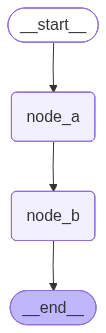

In [7]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [22]:
config: RunnableConfig = {"configurable": {"thread_id": "1"}}
graph.invoke({"foo": ""}, config)
# Lo que ocurre que haec que bar sea la suma de 
# los output de node_a y node_b es que el estado 
# es annotated con la funcion de add, definido al principio

{'foo': 'b', 'bar': ['a', 'b']}

# Comenzamos a revisar la historia

Esta historia o thread esta identificada con un thread identifier

In [15]:
# Consigo el ultimo state snapshot
config = {"configurable": {"thread_id": "1"}}
graph.get_state(config)

StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bda85-64e9-6278-8002-a74342ef7880'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-11-09T20:11:54.863058+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bda85-64e7-6848-8001-e33269bca5ee'}}, tasks=(), interrupts=())

In [ ]:
# Consigo el state snapshot para un momento especifico (chekcpoint)
config = {"configurable": {"thread_id": "1", "checkpoint_id": "1ef663ba-28fe-6528-8002-5a559208592c"}}
graph.get_state(config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1ef663ba-28fe-6528-8002-5a559208592c'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

In [ ]:
# historia de snapshots
list(graph.get_state_history(config))

[StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bda85-64e9-6278-8002-a74342ef7880'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-11-09T20:11:54.863058+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bda85-64e7-6848-8001-e33269bca5ee'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'foo': 'a', 'bar': ['a']}, next=('node_b',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bda85-64e7-6848-8001-e33269bca5ee'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-11-09T20:11:54.862387+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bda85-64e5-6a31-8000-2ba0d1b18eb1'}}, tasks=(PregelTask(id='75407c9a-9d75-12a1-7f5a-e94edc1c10ed', name='node_b', path=('__pregel_pull', 'node_b'), error=None, interrupts

Si se provee con el thread_id y checkpoint_id, podemos recrear la execuion del agente desde un punto. Importante, todo lo que paso anteriormente a ese checkpoint se mantiene como se recuerda, lo subsiguiente se correra de nuevo

In [ ]:
config = {"configurable": {"thread_id": "1", "checkpoint_id": "0c62ca34-ac19-445d-bbb0-5b4984975b2a"}}
graph.invoke(None, config=config)

## Update state

Se puede editar el graph state. Si no especifico, se updateara el ultimo state. Tambien puede 

In [23]:
graph.update_state(config, {"foo": 2, "bar": ["b"]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0bdabc-4ab6-6ec9-8003-bec9cbedf51c'}}

In [24]:
graph.get_state(config)

StateSnapshot(values={'foo': 2, 'bar': ['a', 'b', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bdabc-4ab6-6ec9-8003-bec9cbedf51c'}}, metadata={'source': 'update', 'step': 3, 'parents': {}}, created_at='2025-11-09T20:36:28.511187+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0bdabb-b1ff-6c80-8002-d3a2f3896021'}}, tasks=(), interrupts=())

## Store

Se maneja codo a acodo con el checkpointer. Uno va guardadn olos states al tread y el in_memory_store nos permte guardar info arbitraria para acceder a ella a través de los distintos threads